# E. Vocab

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from glob import glob
import re
import nltk
import seaborn as sns
import plotly_express as px
sns.set()

import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [2]:
data_home = 'C:/Users/user/Desktop/24Spring_ETA_Project/Dataset'
data_prefix = 'Star Wars- Episode '
output_dir = 'C:/Users/user/Desktop/24Spring_ETA_Project/Output'
path_prefix = 'starwars-combo'

OHCO = ['movie_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
MOVIES = OHCO[:1]


CORPUS_og = pd.read_csv(f"{output_dir}/{path_prefix}-CORPUS.csv")
# these terms indicates scene changes, but seems to have importance on tfidf, dfidf and such, so I'm erasing them for better interpretations
terms_to_remove = ['int', 'ext', 'interior', 'exterior']
filtered_CORPUS = CORPUS_og[~CORPUS_og['term_str'].isin(terms_to_remove)]
CORPUS = filtered_CORPUS.set_index(OHCO)
CORPUS

token_str term_str  \
movie_id chap_num para_num sent_num token_num                      
1        1.0      0        0        0                 A        a   
                                    1              vast     vast   
                                    2               sea      sea   
                                    3                of       of   
                                    4             stars    stars   
...                                                 ...      ...   
6        135.0    6        0        2              OVER     over   
                                    3              STAR     star   
                                    4             FIELD    field   
                  7        0        0               THE      the   
                                    1              END}      end   

                                                       pos_tags  pos pos_group  
movie_id chap_num para_num sent_num token_num                                   
1        1.0      0        0        0               ('a', 'DT')   DT        DT  
                                    1            ('vast', 'NN')   NN        NN  
                                    2             ('sea', 'NN')   NN        NN  
                                    3              ('of', 'IN')   IN        IN  
                                    4          ('stars', 'NNS')  NNS        NN  
...                                                         ...  ...       ...  
6        135.0    6        0        2            ('over', 'IN')   IN        IN  
                                    3            ('star', 'NN')   NN        NN  
                                    4           ('field', 'NN')   NN        NN  
                  7        0        0             ('the', 'DT')   DT        DT  
                                    1             ('end', 'NN')   NN        NN  

[173351 rows x 5 columns]

## N, P, I, MAX_POS, MAX_POS_GROUP

In [3]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['n_tokens'] = VOCAB.apply(lambda x: len(x.name.split()), 1)

VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB

,n,p,i,n_chars,n_tokens,max_pos_group,max_pos
term_str,,,,,,,
the,11053,0.063761,3.971186,3,1,DT,DT
and,3991,0.023023,5.440802,3,1,CC,CC
to,3774,0.021771,5.521458,2,1,TO,TO
a,3558,0.020525,5.606486,1,1,DT,DT
of,3101,0.017889,5.804819,2,1,IN,IN
...,...,...,...,...,...,...,...
condemn,1,0.000006,17.403337,7,1,NN,NN
sympaphy,1,0.000006,17.403337,8,1,NN,NN
reproductive,1,0.000006,17.403337,12,1,NN,NN


## STOP

In [4]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [5]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
VOCAB

,n,p,i,n_chars,n_tokens,max_pos_group,max_pos,stop
term_str,,,,,,,,
the,11053,0.063761,3.971186,3,1,DT,DT,1
and,3991,0.023023,5.440802,3,1,CC,CC,1
to,3774,0.021771,5.521458,2,1,TO,TO,1
a,3558,0.020525,5.606486,1,1,DT,DT,1
of,3101,0.017889,5.804819,2,1,IN,IN,1
...,...,...,...,...,...,...,...,...
condemn,1,0.000006,17.403337,7,1,NN,NN,0
sympaphy,1,0.000006,17.403337,8,1,NN,NN,0
reproductive,1,0.000006,17.403337,12,1,NN,NN,0


## Porter_stem

In [6]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [7]:
VOCAB[VOCAB.stem_porter != VOCAB.stem_snowball]

,n,p,i,n_chars,n_tokens,max_pos_group,max_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
his,1558,0.008988,6.797857,3,1,PR,PRP$,1,hi,his,his
this,667,0.003848,8.021794,4,1,DT,DT,1,thi,this,thi
has,328,0.001892,9.045785,3,1,VB,VBZ,1,ha,has,has
was,275,0.001586,9.300049,3,1,VB,VBD,1,wa,was,was
general,168,0.000969,10.011019,7,1,JJ,JJ,0,gener,general,gen
...,...,...,...,...,...,...,...,...,...,...,...
communicates,1,0.000006,17.403337,12,1,NN,NNS,0,commun,communic,commun
forlornly,1,0.000006,17.403337,9,1,RB,RB,0,forlornli,forlorn,forlorn
das,1,0.000006,17.403337,3,1,NN,NNS,0,da,das,das


In [8]:
for stem_type in ['porter', 'snowball', 'lancaster']:
    x = VOCAB[f"stem_{stem_type}"].value_counts().mean()
    print(stem_type, round(x,2))

porter 1.48
snowball 1.51
lancaster 1.72


# Derive Tables

In [9]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [10]:
def gather_docs(CORPUS, ohco_level, term_col='term_str'):
    OHCO = CORPUS.index.names
    CORPUS[term_col] = CORPUS[term_col].astype('str')
    DOC = CORPUS.groupby(OHCO[:ohco_level])[term_col].apply(lambda x:' '.join(x)).to_frame('doc_str')
    return DOC

In [11]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF, DTCM, DF, IDF

In [12]:
BOW_chaps = create_bow(CORPUS, bag=CHAPS)

In [13]:
TFIDF_chaps, DFIDF_chaps, DTCM, DF, IDF = get_tfidf(BOW_chaps, tf_method='max')

## BOW

In [14]:
# TFIDF_chaps[TFIDF_chaps > 0].stack().to_frame('tfidf')

In [15]:
BOW_chaps = BOW_chaps.join(TFIDF_chaps[TFIDF_chaps > 0].stack().to_frame('tfidf'))
BOW_chaps

n     tfidf
movie_id chap_num term_str               
1        1.0      a           6  0.157711
                  ahhh        1  0.268594
                  alarming    1  0.375736
                  all         2  0.169711
                  ambassador  1  0.268594
...                          ..       ...
6        135.0    village     1  0.745336
                  warm        1  0.641926
                  watch       1  0.403014
                  wild        1  0.654426
                  yoda        1  0.403014

[100495 rows x 2 columns]

## DTM

In [16]:
DOC = gather_docs(CORPUS, 2)

In [17]:
DOC['n_tokens'] = DOC.doc_str.apply(lambda x: len(x.split()))
DOC

doc_str  n_tokens
movie_id chap_num                                                             
1        1.0       a vast sea of stars serves as the backdrop for...       270
         2.0       federation battleship docking bay space fx the...        20
         3.0       federation battleship docking bay space a prot...        98
         4.0       federation battleship conference room a door s...       236
         5.0       federation battleship bridge nute gunray and d...        99
...                                                              ...       ...
6        131.0     death star an imperial shuttle with luke alone...        95
         132.0     millennium falcon cockpit lando turns to nien ...       100
         133.0     endor forest han and leia chewie the droids th...       105
         134.0     endor forest night luke sets a torch to the lo...        56
         135.0     ewok village square night a huge bonfire is th...       141

[1469 rows x 2 columns]

In [18]:
count_engine = CountVectorizer(
    # stop_words = 'english',
    # ngram_range = ngram_range
    )

In [19]:
X = count_engine.fit_transform(DOC.doc_str)

In [20]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
DTM = pd.DataFrame(X.toarray(), 
                   columns=count_engine.get_feature_names_out(), 
                   index=DOC.index)

In [22]:
DTM

135a  3b3  3po  44a  523a  9d9  aaaa  aaaggghhh  aaagh  \
movie_id chap_num                                                           
1        1.0          0    0    0    0     0    0     0          0      0   
         2.0          0    0    0    0     0    0     0          0      0   
         3.0          0    0    0    0     0    0     0          0      0   
         4.0          0    0    0    0     0    0     0          0      0   
         5.0          0    0    0    0     0    0     0          0      0   
...                 ...  ...  ...  ...   ...  ...   ...        ...    ...   
6        131.0        0    0    0    0     0    0     0          0      0   
         132.0        2    0    0    0     0    0     0          0      0   
         133.0        0    0    0    0     0    0     0          0      0   
         134.0        0    0    0    0     0    0     0          0      0   
         135.0        0    0    0    0     0    0     0          0      0   

                   aaah  ...  zev  zip  zipping  zips  zone  zones  zoom  \
movie_id chap_num        ...                                               
1        1.0          0  ...    0    0        0     0     0      0     0   
         2.0          0  ...    0    0        0     0     0      0     0   
         3.0          0  ...    0    0        0     0     0      0     0   
         4.0          0  ...    0    0        0     0     0      0     0   
         5.0          0  ...    0    0        0     0     0      0     0   
...                 ...  ...  ...  ...      ...   ...   ...    ...   ...   
6        131.0        0  ...    0    0        0     0     0      0     0   
         132.0        0  ...    0    0        0     0     0      0     0   
         133.0        0  ...    0    0        0     0     0      0     0   
         134.0        0  ...    0    0        0     0     0      0     1   
         135.0        0  ...    0    0        0     0     0      0     0   

                   zooming  zooms  zuckuss  
movie_id chap_num                           
1        1.0             0      0        0  
         2.0             0      0        0  
         3.0             0      0        0  
         4.0             0      0        0  
         5.0             0      0        0  
...                    ...    ...      ...  
6        131.0           0      0        0  
         132.0           0      0        0  
         133.0           0      0        0  
         134.0           0      0        0  
         135.0           0      0        0  

[1469 rows x 9581 columns]

## DFIDF

In [23]:
DFIDF_chaps

term_str
135a        10.520619
3b3         10.520619
3po        146.919062
44a         10.520619
523a        10.520619
              ...    
zones       10.520619
zoom        71.986906
zooming     19.041237
zooms      133.346115
zuckuss     10.520619
Length: 9602, dtype: float64

In [24]:
DFIDF_chaps.sort_values(ascending=False)

term_str
it              779.644989
as              777.906306
he              777.527896
i               776.561198
you             774.759012
                   ...    
k                10.520619
jutting          10.520619
jurisdiction     10.520619
junior           10.520619
zuckuss          10.520619
Length: 9602, dtype: float64

In [25]:
VOCAB['dfidf'] = DFIDF_chaps
VOCAB['df'] = DF
VOCAB['idf'] = IDF
# VOCAB.dfidf.sort_values(ascending=False).head(10)
VOCAB

,n,p,i,n_chars,n_tokens,max_pos_group,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,dfidf,df,idf
term_str,,,,,,,,,,,,,,
the,11053,0.063761,3.971186,3,1,DT,DT,1,the,the,the,169.805957,1346,0.126156
and,3991,0.023023,5.440802,3,1,CC,CC,1,and,and,and,562.766536,991,0.567877
to,3774,0.021771,5.521458,2,1,TO,TO,1,to,to,to,669.594519,852,0.785909
a,3558,0.020525,5.606486,1,1,DT,DT,1,a,a,a,649.137742,882,0.735984
of,3101,0.017889,5.804819,2,1,IN,IN,1,of,of,of,594.944822,953,0.624286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
condemn,1,0.000006,17.403337,7,1,NN,NN,0,condemn,condemn,condemn,10.520619,1,10.520619
sympaphy,1,0.000006,17.403337,8,1,NN,NN,0,sympaphi,sympaphi,sympaph,10.520619,1,10.520619
reproductive,1,0.000006,17.403337,12,1,NN,NN,0,reproduct,reproduct,reproduc,10.520619,1,10.520619


## TFIDF

In [26]:
TFIDF_chaps

term_str               135a  3b3  3po  44a  523a  9d9         a  aaaa  \
movie_id chap_num                                                       
1        1.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.157711   0.0   
         2.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.000000   0.0   
         3.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.210281   0.0   
         4.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.229995   0.0   
         5.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.294394   0.0   
...                     ...  ...  ...  ...   ...  ...       ...   ...   
6        131.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.122664   0.0   
         132.0     5.260309  0.0  0.0  0.0   0.0  0.0  0.367992   0.0   
         133.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.245328   0.0   
         134.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.367992   0.0   
         135.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.133815   0.0   

term_str           aaaggghhh  aaagh  ...  zev  zip  zipping  zips  zone  \
movie_id chap_num                    ...                                  
1        1.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         2.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         3.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         4.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         5.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
...                      ...    ...  ...  ...  ...      ...   ...   ...   
6        131.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         132.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         133.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         134.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         135.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   

term_str           zones      zoom  zooming  zooms  zuckuss  
movie_id chap_num                                            
1        1.0         0.0  0.000000      0.0    0.0      0.0  
         2.0         0.0  0.000000      0.0    0.0      0.0  
         3.0         0.0  0.000000      0.0    0.0      0.0  
         4.0         0.0  0.000000      0.0    0.0      0.0  
         5.0         0.0  0.000000      0.0    0.0      0.0  
...                  ...       ...      ...    ...      ...  
6        131.0       0.0  0.000000      0.0    0.0      0.0  
         132.0       0.0  0.000000      0.0    0.0      0.0  
         133.0       0.0  0.000000      0.0    0.0      0.0  
         134.0       0.0  1.799673      0.0    0.0      0.0  
         135.0       0.0  0.000000      0.0    0.0      0.0  

[1469 rows x 9602 columns]

In [27]:
TFIDF_chaps[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

,term_str,be,going,continuing,so,dooku,cockpit,s,little,my,as
movie_id,chap_num,,,,,,,,,,
5,212.000000,0.185051,0.141765,0.000000,0.148476,0.000000,0.000000,0.221965,0.000000,0.236127,0.119839
3,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55.000000,0.693942,0.000000,0.000000,0.000000,0.000000,0.000000,0.554912,0.000000,0.000000,0.000000
5,97.000000,0.122460,0.187630,0.000000,0.000000,0.000000,0.000000,0.146889,0.000000,0.000000,0.158611
2,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204894,0.090804,0.000000,0.000000,0.147075
4,241.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.502555,0.277456,1.110265,0.000000,0.000000
5,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
VOCAB['mean_tfidf'] = TFIDF_chaps.mean()

## Normalized TFIDF_L2

In [29]:
from scipy.linalg import norm

In [30]:
TFIDF_L2 = (TFIDF_chaps.T / norm(TFIDF_chaps, 2, axis=1)).T
TFIDF_L2

term_str               135a  3b3  3po  44a  523a  9d9         a  aaaa  \
movie_id chap_num                                                       
1        1.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.043349   0.0   
         2.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.000000   0.0   
         3.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.021689   0.0   
         4.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.040859   0.0   
         5.0       0.000000  0.0  0.0  0.0   0.0  0.0  0.022850   0.0   
...                     ...  ...  ...  ...   ...  ...       ...   ...   
6        131.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.034209   0.0   
         132.0     0.396597  0.0  0.0  0.0   0.0  0.0  0.027744   0.0   
         133.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.043104   0.0   
         134.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.034957   0.0   
         135.0     0.000000  0.0  0.0  0.0   0.0  0.0  0.020816   0.0   

term_str           aaaggghhh  aaagh  ...  zev  zip  zipping  zips  zone  \
movie_id chap_num                    ...                                  
1        1.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         2.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         3.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         4.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         5.0             0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
...                      ...    ...  ...  ...  ...      ...   ...   ...   
6        131.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         132.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         133.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         134.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   
         135.0           0.0    0.0  ...  0.0  0.0      0.0   0.0   0.0   

term_str           zones      zoom  zooming  zooms  zuckuss  
movie_id chap_num                                            
1        1.0         0.0  0.000000      0.0    0.0      0.0  
         2.0         0.0  0.000000      0.0    0.0      0.0  
         3.0         0.0  0.000000      0.0    0.0      0.0  
         4.0         0.0  0.000000      0.0    0.0      0.0  
         5.0         0.0  0.000000      0.0    0.0      0.0  
...                  ...       ...      ...    ...      ...  
6        131.0       0.0  0.000000      0.0    0.0      0.0  
         132.0       0.0  0.000000      0.0    0.0      0.0  
         133.0       0.0  0.000000      0.0    0.0      0.0  
         134.0       0.0  0.170956      0.0    0.0      0.0  
         135.0       0.0  0.000000      0.0    0.0      0.0  

[1469 rows x 9602 columns]

In [31]:
a = len(TFIDF_L2)
TFIDF_L2 = TFIDF_L2.dropna()
b = len(TFIDF_L2)
bag_loss = a - b
bag_loss

0

In [32]:
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

# Reduced and Normalized TFIDF_L2

## Select based on dh

In [33]:
DOC2 = DTCM.sum(1).to_frame('n_tokens')
DOC2['n_types'] = DTCM.astype('bool').sum(1)
VOCAB['dp'] = VOCAB.df / len(DOC2)
VOCAB['di'] = np.log2(1/VOCAB.dp)
VOCAB['dh'] = VOCAB.dp * VOCAB.di
VOCAB['n2'] = DTCM.sum()
VOCAB['p2'] = VOCAB.n2 / VOCAB.n2.sum()
VOCAB['i2'] = -np.log2(VOCAB.p2)

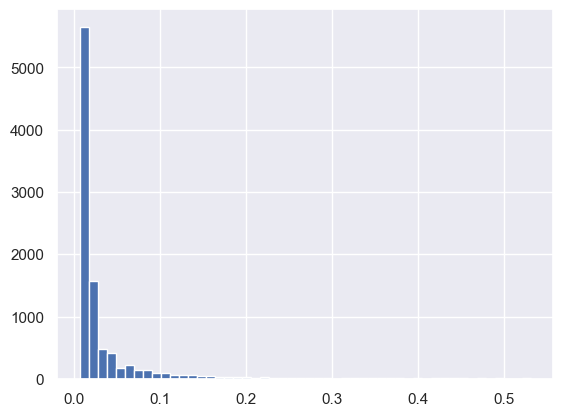

In [34]:
VOCAB.dh.hist(bins=50);

In [35]:
SIGS = VOCAB.sort_values('dh', ascending=False).head(5000)

In [36]:
SIGS[['max_pos', 'n2', 'i2', 'dh']].head(25).style.background_gradient(cmap='YlGnBu')

,max_pos,n2,i2,dh
term_str,,,,
it,PRP,1459.000000,6.892572,0.530732
as,IN,1103.000000,7.296120,0.529548
he,PRP,1407.000000,6.944930,0.529291
i,NN,2409.000000,6.169118,0.528633
you,PRP,2388.000000,6.181750,0.527406
his,PRP$,1558.000000,6.797857,0.526979
at,IN,891.000000,7.604055,0.526425
into,IN,762.000000,7.829689,0.526159
with,IN,924.000000,7.551588,0.525885


In [37]:
R_TFIDF = TFIDF_chaps[SIGS.index]
# tfidf reduced

In [38]:
# L2 = R_TFIDF.apply(lambda x: x / norm(x), 1)
R_N_TFIDF_L2 = (R_TFIDF.T / norm(R_TFIDF, 2, axis=1)).T

In [39]:
a = len(R_N_TFIDF_L2)
R_N_TFIDF_L2 = R_N_TFIDF_L2.dropna()
b = len(R_N_TFIDF_L2)
bag_loss = a - b
bag_loss

0

In [40]:
R_N_TFIDF_L2

term_str                 it        as        he         i       you       his  \
movie_id chap_num                                                               
1        1.0       0.014824  0.041759  0.000000  0.000000  0.016630  0.000000   
         2.0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         3.0       0.000000  0.000000  0.000000  0.056166  0.028717  0.000000   
         4.0       0.067563  0.000000  0.036514  0.074121  0.056846  0.000000   
         5.0       0.022592  0.000000  0.000000  0.123922  0.050687  0.000000   
...                     ...       ...       ...       ...       ...       ...   
6        131.0     0.035563  0.133570  0.000000  0.000000  0.000000  0.063280   
         132.0     0.097560  0.030536  0.000000  0.107030  0.036482  0.057866   
         133.0     0.029293  0.082517  0.063325  0.000000  0.000000  0.052124   
         134.0     0.000000  0.034225  0.039397  0.000000  0.000000  0.032429   
         135.0     0.000000  0.000000  0.025034  0.000000  0.000000  0.020606   

term_str                 at      into      with       out  ...  increases  \
movie_id chap_num                                          ...              
1        1.0       0.033760  0.016943  0.051020  0.017491  ...        0.0   
         2.0       0.000000  0.000000  0.000000  0.000000  ...        0.0   
         3.0       0.058296  0.000000  0.000000  0.000000  ...        0.0   
         4.0       0.038466  0.019305  0.096887  0.039858  ...        0.0   
         5.0       0.000000  0.000000  0.025917  0.026655  ...        0.0   
...                     ...       ...       ...       ...  ...        ...   
6        131.0     0.040494  0.000000  0.081595  0.041959  ...        0.0   
         132.0     0.000000  0.037168  0.037307  0.038370  ...        0.0   
         133.0     0.033355  0.000000  0.000000  0.000000  ...        0.0   
         134.0     0.000000  0.000000  0.000000  0.000000  ...        0.0   
         135.0     0.026373  0.000000  0.000000  0.027327  ...        0.0   

term_str           intensify  fins  rit  prophecy  workbench  prepared  \
movie_id chap_num                                                        
1        1.0             0.0   0.0  0.0       0.0        0.0       0.0   
         2.0             0.0   0.0  0.0       0.0        0.0       0.0   
         3.0             0.0   0.0  0.0       0.0        0.0       0.0   
         4.0             0.0   0.0  0.0       0.0        0.0       0.0   
         5.0             0.0   0.0  0.0       0.0        0.0       0.0   
...                      ...   ...  ...       ...        ...       ...   
6        131.0           0.0   0.0  0.0       0.0        0.0       0.0   
         132.0           0.0   0.0  0.0       0.0        0.0       0.0   
         133.0           0.0   0.0  0.0       0.0        0.0       0.0   
         134.0           0.0   0.0  0.0       0.0        0.0       0.0   
         135.0           0.0   0.0  0.0       0.0        0.0       0.0   

term_str           genetic  negotiate  passenger  
movie_id chap_num                                 
1        1.0           0.0        0.0        0.0  
         2.0           0.0        0.0        0.0  
         3.0           0.0        0.0        0.0  
         4.0           0.0        0.0        0.0  
         5.0           0.0        0.0        0.0  
...                    ...        ...        ...  
6        131.0         0.0        0.0        0.0  
         132.0         0.0        0.0        0.0  
         133.0         0.0        0.0        0.0  
         134.0         0.0        0.0        0.0  
         135.0         0.0        0.0        0.0  

[1469 rows x 5000 columns]

## Select based on tfidf, significant nouns, verbs, and adjectives
selecting the top 5000 significant nouns, verbs, and adjectives

In [41]:
TFIDF_chaps
pos_set = ['NN', 'VB']
VSHORT = VOCAB[VOCAB.max_pos_group.isin(['NN', 'VB', 'JJ']) & ~VOCAB.max_pos.isin(['NNP'])].sort_values('dfidf', ascending=False).head(5000)
R_TFIDF_2 = TFIDF_chaps[VSHORT.index]
R_TFIDF_2

term_str                  i       are        is         t        be     have  \
movie_id chap_num                                                              
1        1.0       0.000000  0.000000  0.127468  0.000000  0.074351  0.00000   
         2.0       0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
         3.0       0.450050  0.243376  0.000000  0.290972  0.594808  0.00000   
         4.0       0.393794  0.212954  0.148713  0.254600  0.520457  0.13602   
         5.0       1.575175  0.681454  0.000000  0.407361  0.000000  0.00000   
...                     ...       ...       ...       ...       ...      ...   
6        131.0     0.000000  0.000000  0.099142  0.000000  0.000000  0.00000   
         132.0     1.181381  0.000000  0.297425  0.509201  0.000000  0.00000   
         133.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
         134.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
         135.0     0.000000  0.000000  0.216309  0.000000  0.000000  0.00000   

term_str           day   cockpit         s      star  ...  approved  counters  \
movie_id chap_num                                     ...                       
1        1.0       0.0  0.241482  0.059455  0.084493  ...       0.0       0.0   
         2.0       0.0  0.000000  0.000000  0.000000  ...       0.0       0.0   
         3.0       0.0  0.000000  0.118910  0.000000  ...       0.0       0.0   
         4.0       0.0  0.000000  0.156069  0.000000  ...       0.0       0.0   
         5.0       0.0  0.000000  0.166474  0.000000  ...       0.0       0.0   
...                ...       ...       ...       ...  ...       ...       ...   
6        131.0     0.0  0.187819  0.000000  0.591450  ...       0.0       0.0   
         132.0     0.0  0.563458  0.000000  1.182900  ...       0.0       0.0   
         133.0     0.0  0.000000  0.092485  0.262867  ...       0.0       0.0   
         134.0     0.0  0.000000  0.208092  0.000000  ...       0.0       0.0   
         135.0     0.0  0.000000  0.075670  0.215073  ...       0.0       0.0   

term_str           repeating  disappointed  tightening  unconsciousness  \
movie_id chap_num                                                         
1        1.0             0.0           0.0         0.0              0.0   
         2.0             0.0           0.0         0.0              0.0   
         3.0             0.0           0.0         0.0              0.0   
         4.0             0.0           0.0         0.0              0.0   
         5.0             0.0           0.0         0.0              0.0   
...                      ...           ...         ...              ...   
6        131.0           0.0           0.0         0.0              0.0   
         132.0           0.0           0.0         0.0              0.0   
         133.0           0.0           0.0         0.0              0.0   
         134.0           0.0           0.0         0.0              0.0   
         135.0           0.0           0.0         0.0              0.0   

term_str           fearsome  shuffles  groan  baggy  
movie_id chap_num                                    
1        1.0            0.0       0.0    0.0    0.0  
         2.0            0.0       0.0    0.0    0.0  
         3.0            0.0       0.0    0.0    0.0  
         4.0            0.0       0.0    0.0    0.0  
         5.0            0.0       0.0    0.0    0.0  
...                     ...       ...    ...    ...  
6        131.0          0.0       0.0    0.0    0.0  
         132.0          0.0       0.0    0.0    0.0  
         133.0          0.0       0.0    0.0    0.0  
         134.0          0.0       0.0    0.0    0.0  
         135.0          0.0       0.0    0.0    0.0  

[1469 rows x 5000 columns]

In [42]:
R_N_TFIDF_L2_2 = (R_TFIDF_2.T / norm(R_TFIDF_2, 2, axis=1)).T

In [43]:
a = len(R_N_TFIDF_L2_2)
R_N_TFIDF_L2_2 = R_N_TFIDF_L2_2.dropna()
b = len(R_N_TFIDF_L2_2)
bag_loss = a - b
bag_loss

0

In [44]:
R_N_TFIDF_L2_2

term_str                  i       are        is         t        be      have  \
movie_id chap_num                                                               
1        1.0       0.000000  0.000000  0.038912  0.000000  0.022697  0.000000   
         2.0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         3.0       0.050536  0.027328  0.000000  0.032673  0.066790  0.000000   
         4.0       0.093420  0.050520  0.035279  0.060399  0.123469  0.032268   
         5.0       0.126249  0.054618  0.000000  0.032650  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
6        131.0     0.000000  0.000000  0.032471  0.000000  0.000000  0.000000   
         132.0     0.125206  0.000000  0.031522  0.053966  0.000000  0.000000   
         133.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         134.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         135.0     0.000000  0.000000  0.040824  0.000000  0.000000  0.000000   

term_str           day   cockpit         s      star  ...  approved  counters  \
movie_id chap_num                                     ...                       
1        1.0       0.0  0.073717  0.018150  0.025793  ...       0.0       0.0   
         2.0       0.0  0.000000  0.000000  0.000000  ...       0.0       0.0   
         3.0       0.0  0.000000  0.013352  0.000000  ...       0.0       0.0   
         4.0       0.0  0.000000  0.037025  0.000000  ...       0.0       0.0   
         5.0       0.0  0.000000  0.013343  0.000000  ...       0.0       0.0   
...                ...       ...       ...       ...  ...       ...       ...   
6        131.0     0.0  0.061514  0.000000  0.193711  ...       0.0       0.0   
         132.0     0.0  0.059717  0.000000  0.125367  ...       0.0       0.0   
         133.0     0.0  0.000000  0.020292  0.057674  ...       0.0       0.0   
         134.0     0.0  0.000000  0.023223  0.000000  ...       0.0       0.0   
         135.0     0.0  0.000000  0.014281  0.040591  ...       0.0       0.0   

term_str           repeating  disappointed  tightening  unconsciousness  \
movie_id chap_num                                                         
1        1.0             0.0           0.0         0.0              0.0   
         2.0             0.0           0.0         0.0              0.0   
         3.0             0.0           0.0         0.0              0.0   
         4.0             0.0           0.0         0.0              0.0   
         5.0             0.0           0.0         0.0              0.0   
...                      ...           ...         ...              ...   
6        131.0           0.0           0.0         0.0              0.0   
         132.0           0.0           0.0         0.0              0.0   
         133.0           0.0           0.0         0.0              0.0   
         134.0           0.0           0.0         0.0              0.0   
         135.0           0.0           0.0         0.0              0.0   

term_str           fearsome  shuffles  groan  baggy  
movie_id chap_num                                    
1        1.0            0.0       0.0    0.0    0.0  
         2.0            0.0       0.0    0.0    0.0  
         3.0            0.0       0.0    0.0    0.0  
         4.0            0.0       0.0    0.0    0.0  
         5.0            0.0       0.0    0.0    0.0  
...                     ...       ...    ...    ...  
6        131.0          0.0       0.0    0.0    0.0  
         132.0          0.0       0.0    0.0    0.0  
         133.0          0.0       0.0    0.0    0.0  
         134.0          0.0       0.0    0.0    0.0  
         135.0          0.0       0.0    0.0    0.0  

[1469 rows x 5000 columns]

# Save

In [45]:
BOW_chaps.to_csv(f"{output_dir}/{path_prefix}-BOW.csv", index=True)
DFIDF_chaps.to_csv(f"{output_dir}/other/{path_prefix}-DFIDF.csv", index=True)
TFIDF_chaps.to_csv(f"{output_dir}/{path_prefix}-TFIDF.csv", index=True)
TFIDF_L2.to_csv(f"{output_dir}/other/{path_prefix}-TFIDF_L2.csv", index=True)
R_N_TFIDF_L2.to_csv(f"{output_dir}/{path_prefix}-red_norm_TFIDF_L2.csv", index=True)
R_N_TFIDF_L2_2.to_csv(f"{output_dir}/{path_prefix}-red_norm_TFIDF_L2_2.csv", index=True)
DTCM.to_csv(f"{output_dir}/other/{path_prefix}-DTCM.csv", index=True)
DTM.to_csv(f"{output_dir}/{path_prefix}-DTM.csv", index=True)

In [46]:
VOCAB

,n,p,i,n_chars,n_tokens,max_pos_group,max_pos,stop,stem_porter,stem_snowball,...,dfidf,df,idf,mean_tfidf,dp,di,dh,n2,p2,i2
term_str,,,,,,,,,,,,,,,,,,,,,
the,11053,0.063761,3.971186,3,1,DT,DT,1,the,the,...,169.805957,1346,0.126156,0.101679,0.916270,0.126156,0.115593,11053.0,0.063761,3.971186
and,3991,0.023023,5.440802,3,1,CC,CC,1,and,and,...,562.766536,991,0.567877,0.153266,0.674609,0.567877,0.383095,3991.0,0.023023,5.440802
to,3774,0.021771,5.521458,2,1,TO,TO,1,to,to,...,669.594519,852,0.785909,0.179453,0.579986,0.785909,0.455817,3774.0,0.021771,5.521458
a,3558,0.020525,5.606486,1,1,DT,DT,1,a,a,...,649.137742,882,0.735984,0.179472,0.600408,0.735984,0.441891,3558.0,0.020525,5.606486
of,3101,0.017889,5.804819,2,1,IN,IN,1,of,of,...,594.944822,953,0.624286,0.143159,0.648741,0.624286,0.405000,3101.0,0.017889,5.804819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
condemn,1,0.000006,17.403337,7,1,NN,NN,0,condemn,condemn,...,10.520619,1,10.520619,0.000326,0.000681,10.520619,0.007162,1.0,0.000006,17.403337
sympaphy,1,0.000006,17.403337,8,1,NN,NN,0,sympaphi,sympaphi,...,10.520619,1,10.520619,0.000326,0.000681,10.520619,0.007162,1.0,0.000006,17.403337
reproductive,1,0.000006,17.403337,12,1,NN,NN,0,reproduct,reproduct,...,10.520619,1,10.520619,0.001194,0.000681,10.520619,0.007162,1.0,0.000006,17.403337


In [47]:
VOCAB.to_csv(f"{output_dir}/{path_prefix}-VOCAB.csv", index=True)

top 20 significant words in the corpus by DFIDF

In [48]:
VOCAB.dfidf.sort_values(ascending=False).head(20)

term_str
it      779.644989
as      777.906306
he      777.527896
i       776.561198
you     774.759012
his     774.131486
at      773.318251
into    772.927688
with    772.524872
out     769.107868
are     768.339411
on      766.167961
is      766.167961
for     749.829636
they    747.577639
up      746.651208
from    746.651208
we      734.916875
by      732.095838
that    730.355610
Name: dfidf, dtype: float64

In [49]:
TFIDF_L2

term_str               135a       3b3       3po       44a      523a       9d9  \
movie_id chap_num                                                               
1        1.0      -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         2.0      -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         3.0      -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         4.0      -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         5.0      -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
...                     ...       ...       ...       ...       ...       ...   
6        131.0    -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         132.0     0.396327 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         133.0    -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         134.0    -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   
         135.0    -0.000270 -0.000078 -0.003617 -0.000122 -0.000023 -0.000111   

term_str                  a      aaaa  aaaggghhh     aaagh  ...       zev  \
movie_id chap_num                                           ...             
1        1.0       0.020993 -0.000043  -0.000155 -0.000053  ... -0.002386   
         2.0      -0.022356 -0.000043  -0.000155 -0.000053  ... -0.002386   
         3.0      -0.000667 -0.000043  -0.000155 -0.000053  ... -0.002386   
         4.0       0.018504 -0.000043  -0.000155 -0.000053  ... -0.002386   
         5.0       0.000494 -0.000043  -0.000155 -0.000053  ... -0.002386   
...                     ...       ...        ...       ...  ...       ...   
6        131.0     0.011853 -0.000043  -0.000155 -0.000053  ... -0.002386   
         132.0     0.005389 -0.000043  -0.000155 -0.000053  ... -0.002386   
         133.0     0.020748 -0.000043  -0.000155 -0.000053  ... -0.002386   
         134.0     0.012601 -0.000043  -0.000155 -0.000053  ... -0.002386   
         135.0    -0.001540 -0.000043  -0.000155 -0.000053  ... -0.002386   

term_str                zip   zipping      zips      zone     zones      zoom  \
movie_id chap_num                                                               
1        1.0      -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         2.0      -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         3.0      -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         4.0      -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         5.0      -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
...                     ...       ...       ...       ...       ...       ...   
6        131.0    -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         132.0    -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         133.0    -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   
         134.0    -0.000024 -0.000076 -0.000596 -0.000277 -0.000144  0.168737   
         135.0    -0.000024 -0.000076 -0.000596 -0.000277 -0.000144 -0.002218   

term_str            zooming     zooms   zuckuss  
movie_id chap_num                                
1        1.0      -0.000244 -0.003493 -0.000078  
         2.0      -0.000244 -0.003493 -0.000078  
         3.0      -0.000244 -0.003493 -0.000078  
         4.0      -0.000244 -0.003493 -0.000078  
         5.0      -0.000244 -0.003493 -0.000078  
...                     ...       ...       ...  
6        131.0    -0.000244 -0.003493 -0.000078  
         132.0    -0.000244 -0.003493 -0.000078  
         133.0    -0.000244 -0.003493 -0.000078  
         134.0    -0.000244 -0.003493 -0.000078  
         135.0    -0.000244 -0.003493 -0.000078  

[1469 rows x 9602 columns]

In [50]:
R_N_TFIDF_L2

term_str                 it        as        he         i       you       his  \
movie_id chap_num                                                               
1        1.0       0.014824  0.041759  0.000000  0.000000  0.016630  0.000000   
         2.0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         3.0       0.000000  0.000000  0.000000  0.056166  0.028717  0.000000   
         4.0       0.067563  0.000000  0.036514  0.074121  0.056846  0.000000   
         5.0       0.022592  0.000000  0.000000  0.123922  0.050687  0.000000   
...                     ...       ...       ...       ...       ...       ...   
6        131.0     0.035563  0.133570  0.000000  0.000000  0.000000  0.063280   
         132.0     0.097560  0.030536  0.000000  0.107030  0.036482  0.057866   
         133.0     0.029293  0.082517  0.063325  0.000000  0.000000  0.052124   
         134.0     0.000000  0.034225  0.039397  0.000000  0.000000  0.032429   
         135.0     0.000000  0.000000  0.025034  0.000000  0.000000  0.020606   

term_str                 at      into      with       out  ...  increases  \
movie_id chap_num                                          ...              
1        1.0       0.033760  0.016943  0.051020  0.017491  ...        0.0   
         2.0       0.000000  0.000000  0.000000  0.000000  ...        0.0   
         3.0       0.058296  0.000000  0.000000  0.000000  ...        0.0   
         4.0       0.038466  0.019305  0.096887  0.039858  ...        0.0   
         5.0       0.000000  0.000000  0.025917  0.026655  ...        0.0   
...                     ...       ...       ...       ...  ...        ...   
6        131.0     0.040494  0.000000  0.081595  0.041959  ...        0.0   
         132.0     0.000000  0.037168  0.037307  0.038370  ...        0.0   
         133.0     0.033355  0.000000  0.000000  0.000000  ...        0.0   
         134.0     0.000000  0.000000  0.000000  0.000000  ...        0.0   
         135.0     0.026373  0.000000  0.000000  0.027327  ...        0.0   

term_str           intensify  fins  rit  prophecy  workbench  prepared  \
movie_id chap_num                                                        
1        1.0             0.0   0.0  0.0       0.0        0.0       0.0   
         2.0             0.0   0.0  0.0       0.0        0.0       0.0   
         3.0             0.0   0.0  0.0       0.0        0.0       0.0   
         4.0             0.0   0.0  0.0       0.0        0.0       0.0   
         5.0             0.0   0.0  0.0       0.0        0.0       0.0   
...                      ...   ...  ...       ...        ...       ...   
6        131.0           0.0   0.0  0.0       0.0        0.0       0.0   
         132.0           0.0   0.0  0.0       0.0        0.0       0.0   
         133.0           0.0   0.0  0.0       0.0        0.0       0.0   
         134.0           0.0   0.0  0.0       0.0        0.0       0.0   
         135.0           0.0   0.0  0.0       0.0        0.0       0.0   

term_str           genetic  negotiate  passenger  
movie_id chap_num                                 
1        1.0           0.0        0.0        0.0  
         2.0           0.0        0.0        0.0  
         3.0           0.0        0.0        0.0  
         4.0           0.0        0.0        0.0  
         5.0           0.0        0.0        0.0  
...                    ...        ...        ...  
6        131.0         0.0        0.0        0.0  
         132.0         0.0        0.0        0.0  
         133.0         0.0        0.0        0.0  
         134.0         0.0        0.0        0.0  
         135.0         0.0        0.0        0.0  

[1469 rows x 5000 columns]

In [51]:
R_N_TFIDF_L2_2

term_str                  i       are        is         t        be      have  \
movie_id chap_num                                                               
1        1.0       0.000000  0.000000  0.038912  0.000000  0.022697  0.000000   
         2.0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         3.0       0.050536  0.027328  0.000000  0.032673  0.066790  0.000000   
         4.0       0.093420  0.050520  0.035279  0.060399  0.123469  0.032268   
         5.0       0.126249  0.054618  0.000000  0.032650  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
6        131.0     0.000000  0.000000  0.032471  0.000000  0.000000  0.000000   
         132.0     0.125206  0.000000  0.031522  0.053966  0.000000  0.000000   
         133.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         134.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         135.0     0.000000  0.000000  0.040824  0.000000  0.000000  0.000000   

term_str           day   cockpit         s      star  ...  approved  counters  \
movie_id chap_num                                     ...                       
1        1.0       0.0  0.073717  0.018150  0.025793  ...       0.0       0.0   
         2.0       0.0  0.000000  0.000000  0.000000  ...       0.0       0.0   
         3.0       0.0  0.000000  0.013352  0.000000  ...       0.0       0.0   
         4.0       0.0  0.000000  0.037025  0.000000  ...       0.0       0.0   
         5.0       0.0  0.000000  0.013343  0.000000  ...       0.0       0.0   
...                ...       ...       ...       ...  ...       ...       ...   
6        131.0     0.0  0.061514  0.000000  0.193711  ...       0.0       0.0   
         132.0     0.0  0.059717  0.000000  0.125367  ...       0.0       0.0   
         133.0     0.0  0.000000  0.020292  0.057674  ...       0.0       0.0   
         134.0     0.0  0.000000  0.023223  0.000000  ...       0.0       0.0   
         135.0     0.0  0.000000  0.014281  0.040591  ...       0.0       0.0   

term_str           repeating  disappointed  tightening  unconsciousness  \
movie_id chap_num                                                         
1        1.0             0.0           0.0         0.0              0.0   
         2.0             0.0           0.0         0.0              0.0   
         3.0             0.0           0.0         0.0              0.0   
         4.0             0.0           0.0         0.0              0.0   
         5.0             0.0           0.0         0.0              0.0   
...                      ...           ...         ...              ...   
6        131.0           0.0           0.0         0.0              0.0   
         132.0           0.0           0.0         0.0              0.0   
         133.0           0.0           0.0         0.0              0.0   
         134.0           0.0           0.0         0.0              0.0   
         135.0           0.0           0.0         0.0              0.0   

term_str           fearsome  shuffles  groan  baggy  
movie_id chap_num                                    
1        1.0            0.0       0.0    0.0    0.0  
         2.0            0.0       0.0    0.0    0.0  
         3.0            0.0       0.0    0.0    0.0  
         4.0            0.0       0.0    0.0    0.0  
         5.0            0.0       0.0    0.0    0.0  
...                     ...       ...    ...    ...  
6        131.0          0.0       0.0    0.0    0.0  
         132.0          0.0       0.0    0.0    0.0  
         133.0          0.0       0.0    0.0    0.0  
         134.0          0.0       0.0    0.0    0.0  
         135.0          0.0       0.0    0.0    0.0  

[1469 rows x 5000 columns]

In [52]:
R_N_TFIDF_L2
R_N_TFIDF_L2_2

df1 = pd.DataFrame(R_N_TFIDF_L2.columns.difference(R_N_TFIDF_L2_2.columns))
df2 = pd.DataFrame(R_N_TFIDF_L2_2.columns.difference(R_N_TFIDF_L2.columns))

In [53]:
df1.sample(5)

,term_str
260,pretty
318,them
56,ben
259,precariously
119,extremely


In [54]:
df2.sample(5)

,term_str
301,snoring
223,motti
227,nightmare
161,giddean
89,crossbow
